In [4]:
import numpy as np # array operations
import pandas as pd # dataframe operations
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt 
from matplotlib.ticker import (MultipleLocator,FormatStrFormatter,AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D

# Machine learning related functions
from sklearn.preprocessing import StandardScaler #normalizing inputs
from sklearn.decomposition import PCA  # principal component analysis
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tqdm.auto import tqdm #progress bar 
from warnings import filterwarnings #disable warnings
filterwarnings('ignore')
from IPython import display 
%matplotlib inline

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Rate_dataset_cleaned.csv to Rate_dataset_cleaned.csv


## Data preprocessing

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# reading the data
df = pd.read_csv('Yield_dataset_cleaned.csv', sep=",")
df['Catalyst'] = df['Catalyst ']
#df= df.drop(columns=['Catalyst ','Time (min)','V(pore) (cm3/g)'])
df= df.drop(columns=['Catalyst '])
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# removing DMSO from the dataset (outliers)
df_3 =df.loc[df['phase_2']=='DMSO']
df_4 =df.loc[df['phase_1']=='DMSO']
print(df_3.shape,df_4.shape)
df = df[df.phase_2 !='DMSO']
df = df[df.phase_1 !='DMSO']

(16, 28) (0, 28)


In [ ]:
#Handling typos
df.loc[df['Type of catalyst'] =='Transition Metal Zolite','Type of catalyst'] = 'Transition Metal Zeolite'
df.loc[df['Type of catalyst'] =='Protonated Zeolites','Type of catalyst'] = 'Protonated Zeolite'
df.loc[df['Substrate'] =='Fructose ','Substrate'] = 'Fructose'
df.loc[df['Solvent system'] =='Single Phase','Solvent system'] = 'Single phase'
df.loc[df['Solvent system'] =='Biphasic ','Solvent system'] = 'Biphasic'
df.loc[df['phase_1'] =='water','phase_1'] = 'Water'
df.loc[df['phase_1'] =='Water ','phase_1'] = 'Water'
df.loc[df['phase_1'] =='THF ','phase_1'] = 'THF'
df.loc[df['phase_2'] =='THF ','phase_2'] = 'THF'

In [ ]:
#handling Nan
df['phase_2'] = df['phase_2'].fillna("one_phase")
for i in ['Surface area (m2/g) BET','V(mic) (cm3/g)','TPD (NH3) (micmol/g)','V(pore) (cm3/g)']:
    df[i] = df[i].fillna(df.groupby('Catalyst')[i].transform('mean'))

In [ ]:
df =df.loc[df['Substrate']=='Fructose']
# remove mesopore vol because of high correlation
df = df.drop(columns=['Substrate','M/Al (ie Sn, Cu..)','Lewis/Brosnted  acid Sites','Flow/Batch','Heating'])
df = df[df['Si/Al'].notna()]

In [ ]:
df= df[df["phase_2"]!= "NMP"]
df = df[df["phase_1"]!= 'NaCl (aq)']
df = df[df['HMF Selectivity']!= 0]

In [ ]:
df.shape

(104, 23)

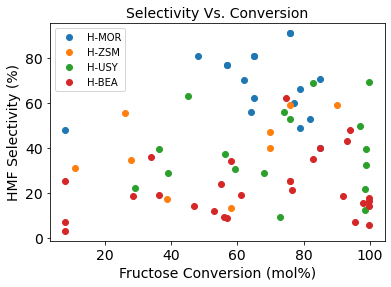

In [ ]:
plt.plot(df[df['Catalyst']=='H-MOR']['Fructose Conversion'], df[df['Catalyst']=='H-MOR']['HMF Selectivity'], 'o', label= "H-MOR")
plt.plot(df[df['Catalyst']=='H-ZSM-5']['Fructose Conversion'], df[df['Catalyst']=='H-ZSM-5']['HMF Selectivity'], 'o', label= "H-ZSM")
plt.plot(df[df['Catalyst']=='H-USY']['Fructose Conversion'], df[df['Catalyst']=='H-USY']['HMF Selectivity'], 'o', label= "H-USY")
plt.plot(df[df['Catalyst']=='H-BEA']['Fructose Conversion'], df[df['Catalyst']=='H-BEA']['HMF Selectivity'], 'o', label= "H-BEA")
plt.legend()
plt.ylabel("HMF Selectivity (%)",fontsize=14)
plt.xlabel("Fructose Conversion (mol%)",fontsize=14)
plt.title("Selectivity Vs. Conversion", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/selectivity_conversion_yield.png", bbox_inches='tight', dpi = 160)

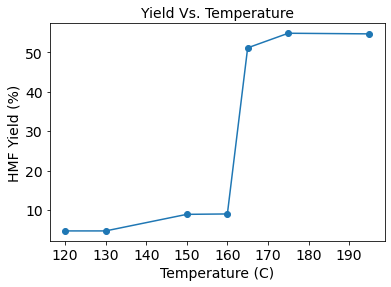

In [ ]:
x = [120,130,150,160,165,175,195]
y = [4.7,4.7,8.9,9,51.1, 54.8, 54.64]
plt.plot(x,y,'-o')
plt.xlabel("Temperature (C)",fontsize=14)
plt.ylabel("HMF Yield (%)",fontsize=14)
plt.title("Yield Vs. Temperature", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Yield_Temperature_yield.png", bbox_inches='tight', dpi = 160)

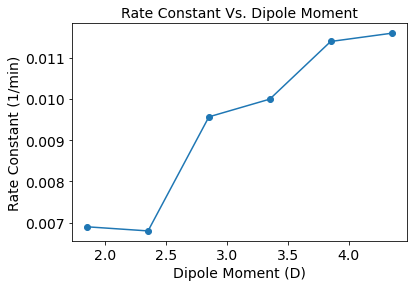

In [ ]:
x = [1.85,2.35,2.85,3.35,3.85,4.35]
y = [0.0069,0.0068, 0.00957,0.01,0.0114,0.0116]
plt.plot(x,y,'-o')
plt.xlabel("Dipole Moment (D)",fontsize=14)
plt.ylabel("Rate Constant (1/min)",fontsize=14)
plt.title("Rate Constant Vs. Dipole Moment", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/k_Temperature_Dipole.png", bbox_inches='tight', dpi = 160)

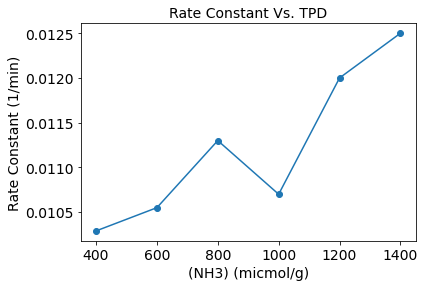

In [ ]:
x = [400,600,800,1000,1200,1400]
y= [0.01029,0.01055,0.0113,0.0107,0.012, 0.0125]
plt.plot(x,y,'-o')
plt.xlabel("(NH3) (micmol/g)",fontsize=14)
plt.ylabel("Rate Constant (1/min)",fontsize=14)
plt.title("Rate Constant Vs. TPD", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/K_TPD.png", bbox_inches='tight', dpi = 160)

In [ ]:
plt.plot(df[df['Temperature ( °C)']==120]['Fructose Conversion'], df[df['Catalyst']=='H-MOR']['HMF Selectivity'], 'o', label= "H-MOR")
plt.plot(df[df['Catalyst']=='H-ZSM-5']['Fructose Conversion'], df[df['Catalyst']=='H-ZSM-5']['HMF Selectivity'], 'o', label= "H-ZSM")
plt.plot(df[df['Catalyst']=='H-USY']['Fructose Conversion'], df[df['Catalyst']=='H-USY']['HMF Selectivity'], 'o', label= "H-USY")
plt.plot(df[df['Catalyst']=='H-BEA']['Fructose Conversion'], df[df['Catalyst']=='H-BEA']['HMF Selectivity'], 'o', label= "H-BEA")

In [ ]:
df['Catalyst'] = df['Catalyst'].astype('category')
cat_dict =dict(enumerate(df['Catalyst'].cat.categories ))

In [ ]:
#label encoding
for i in ['Type of catalyst','Catalyst','Solvent system','phase_1','phase_2']:
    df[i] = df[i].astype('category')
    df[i] = df[i].cat.codes
df.dtypes

Type of catalyst                   int8
Si/Al                           float64
Surface area (m2/g) BET         float64
Avg_pore_diameter(nm)           float64
V(pore) (cm3/g)                 float64
V(mic) (cm3/g)                  float64
V(mesopore) (cm3/g)             float64
TPD (NH3) (micmol/g)            float64
Catalyst/Substrate loading\n    float64
Solvent system                     int8
phase_1                            int8
phase_2                            int8
phase_2/phase_1                 float64
organic solvent                   int64
Total dipole moment(D)          float64
Organic dipole                  float64
Temperature ( °C)                 int64
Time (min)                        int64
HMF Yield                       float64
Fructose Conversion             float64
HMF Selectivity                 float64
Unnamed: 27                     float64
Catalyst                           int8
dtype: object

In [ ]:
#df= df.drop(columns=['Type of catalyst','Solvent system','phase_1','phase_2','Catalyst','organic solvent','Organic dipole','Time (min)','V(mesopore) (cm3/g)'])
df= df.drop(columns=['organic solvent','Organic dipole','Time (min)','V(mesopore) (cm3/g)','Type of catalyst','Catalyst','Unnamed: 27'])

,Si/Al,Surface area (m2/g) BET,Avg_pore_diameter(nm),V(pore) (cm3/g),V(mic) (cm3/g),TPD (NH3) (micmol/g),Catalyst/Substrate loading\n,Solvent system,phase_1,phase_2,phase_2/phase_1,Total dipole moment(D),Temperature ( °C),HMF Yield,Fructose Conversion,HMF Selectivity
0,11.70,461.000000,0.59,0.300000,0.210000,1100.000000,0.200000,0,0,10,3.0,10.295000,165,53.00000,79.00,66.000000
1,11.70,461.000000,0.59,0.300000,0.210000,1100.000000,0.200000,1,0,16,0.0,1.850000,165,34.00000,85.00,40.000000
2,13.00,442.000000,0.55,0.208167,0.180000,966.000000,0.200000,0,0,10,3.0,10.295000,165,45.00000,76.00,59.000000
3,13.00,442.000000,0.55,0.208167,0.180000,966.000000,0.200000,1,0,16,0.0,1.850000,165,20.00000,76.00,25.000000
4,15.60,610.000000,0.67,0.537600,0.220000,860.000000,0.200000,0,0,10,3.0,10.295000,165,30.00000,83.00,35.000000
5,15.60,610.000000,0.67,0.537600,0.220000,860.000000,0.200000,1,0,16,0.0,1.850000,165,20.00000,76.00,25.000000
6,50.00,365.000000,0.55,0.236000,0.144000,411.300000,0.133333,1,0,16,0.0,1.850000,130,8.00000,58.00,13.000000
7,50.00,470.000000,0.55,0.449000,0.138000,351.900000,0.133333,1,0,16,0.0,1.850000,130,16.00000,66.00,24.000000
8,60.00,953.000000,0.74,0.647000,0.359000,248.600000,0.133333,1,0,16,0.0,1.850000,130,7.00000,73.00,9.000000
9,53.00,1219.000000,0.74,1.301000,0.289000,226.900000,0.133333,1,0,16,0.0,1.850000,130,11.00000,75.00,15.000000


In [ ]:
df_2 = df.dropna()

In [ ]:
df.columns

Index(['Si/Al', 'Surface area (m2/g) BET', 'Avg_pore_diameter(nm)',
       'V(pore) (cm3/g)', 'V(mic) (cm3/g)', 'TPD (NH3) (micmol/g)',
       'Catalyst/Substrate loading\n', 'Solvent system', 'phase_1', 'phase_2',
       'phase_2/phase_1', 'Total dipole moment(D)', 'Temperature ( °C)',
       'HMF Yield', 'Fructose Conversion', 'HMF Selectivity'],
      dtype='object')

No handles with labels found to put in legend.


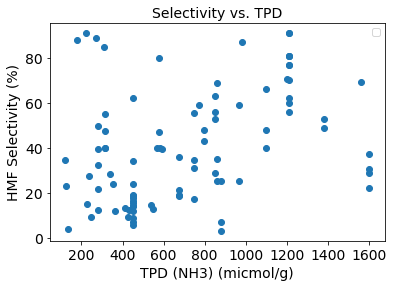

In [ ]:
plt.plot(df_2['TPD (NH3) (micmol/g)'], df_2['HMF Selectivity'], 'o')
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel("TPD (NH3) (micmol/g)", fontsize=14)
plt.ylabel("HMF Selectivity (%)",fontsize=14)
plt.title("Selectivity vs. TPD", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/TPD_selectivity.png", bbox_inches='tight', dpi = 160)

No handles with labels found to put in legend.


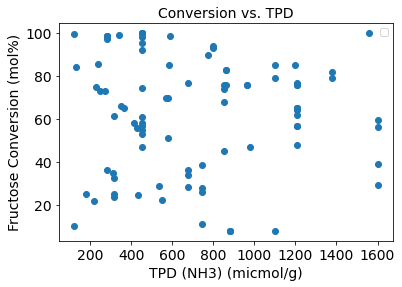

In [ ]:
plt.plot(df_2['TPD (NH3) (micmol/g)'], df_2['Fructose Conversion'], 'o')
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel("TPD (NH3) (micmol/g)", fontsize=14)
plt.ylabel("Fructose Conversion (mol%)",fontsize=14)
plt.title("Conversion vs. TPD", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/TPD_conversion.png", bbox_inches='tight', dpi = 160)

In [ ]:
df = df.drop(columns= ['Fructose Conversion', 'HMF Selectivity','phase_1', 'phase_2'] )
# based on feature importance: 
#df = df.drop(columns=['inorganic solvent','Surface area (m2/g) BET','Type of catalyst','Catalyst','V(mesopore) (cm3/g)','V(pore) (cm3/g)','V(mic) (cm3/g)'])
#df_2 = df[df['V(pore) (cm3/g)'].isna()]
df = df.dropna()
#df = df.fillna(df.mean())  
df.shape

(99, 12)

In [ ]:
df

,Si/Al,Surface area (m2/g) BET,Avg_pore_diameter(nm),V(pore) (cm3/g),V(mic) (cm3/g),TPD (NH3) (micmol/g),Catalyst/Substrate loading\n,Solvent system,phase_2/phase_1,Total dipole moment(D),Temperature ( °C),HMF Yield
0,11.70,461.000000,0.59,0.300000,0.210000,1100.000000,0.200000,0,3.0,10.295000,165,53.00000
1,11.70,461.000000,0.59,0.300000,0.210000,1100.000000,0.200000,1,0.0,1.850000,165,34.00000
2,13.00,442.000000,0.55,0.208167,0.180000,966.000000,0.200000,0,3.0,10.295000,165,45.00000
3,13.00,442.000000,0.55,0.208167,0.180000,966.000000,0.200000,1,0.0,1.850000,165,20.00000
4,15.60,610.000000,0.67,0.537600,0.220000,860.000000,0.200000,0,3.0,10.295000,165,30.00000
5,15.60,610.000000,0.67,0.537600,0.220000,860.000000,0.200000,1,0.0,1.850000,165,20.00000
6,50.00,365.000000,0.55,0.236000,0.144000,411.300000,0.133333,1,0.0,1.850000,130,8.00000
7,50.00,470.000000,0.55,0.449000,0.138000,351.900000,0.133333,1,0.0,1.850000,130,16.00000
8,60.00,953.000000,0.74,0.647000,0.359000,248.600000,0.133333,1,0.0,1.850000,130,7.00000
9,53.00,1219.000000,0.74,1.301000,0.289000,226.900000,0.133333,1,0.0,1.850000,130,11.00000


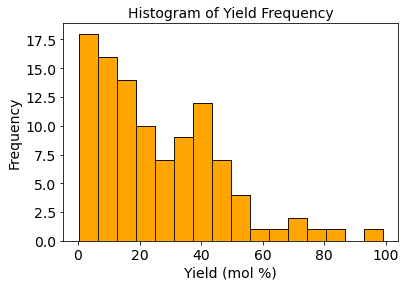

In [ ]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(df['HMF Yield'], color = 'Orange', edgecolor = 'black',
         bins = int(80/5))

# seaborn histogram
sns.distplot(df['HMF Yield'], hist=True, kde=False, 
             bins=int(80/5), color = 'Orange',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Yield Frequency', fontsize= 14)
plt.xlabel('Yield (mol %)',fontsize= 14)
plt.ylabel('Frequency',fontsize= 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Distribution.png", bbox_inches='tight', dpi = 160)

In [ ]:
df.describe()

,Si/Al,Surface area (m2/g) BET,Avg_pore_diameter(nm),V(pore) (cm3/g),V(mic) (cm3/g),TPD (NH3) (micmol/g),Catalyst/Substrate loading\n,Solvent system,phase_1,phase_2,phase_2/phase_1,Total dipole moment(D),Temperature ( °C),HMF Yield,Fructose Conversion,HMF Selectivity
count,104.000000,104.000000,104.000000,99.000000,102.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,97.000000,97.000000
mean,23.240673,617.608276,0.661154,0.405690,0.202602,688.261750,0.351376,0.384615,-0.201923,10.355769,23.307692,3.393782,149.855769,25.781183,62.746804,39.221497
std,19.438879,195.266040,0.072209,0.176062,0.061785,412.923636,0.268325,0.488860,0.403379,3.856449,38.881717,3.045406,16.930135,20.045160,27.669797,25.683265
min,2.600000,212.100000,0.550000,0.178000,0.090780,80.000000,0.100000,0.000000,-1.000000,0.000000,0.000000,0.450000,100.000000,0.240000,5.000000,0.200000
25%,11.700000,482.714286,0.590000,0.300000,0.154880,316.000000,0.200000,0.000000,0.000000,8.750000,1.000000,1.850000,138.750000,9.200000,39.000000,17.800000
50%,15.300000,528.500000,0.670000,0.352000,0.197750,580.000000,0.285714,0.000000,0.000000,10.000000,5.000000,2.641667,155.000000,20.000000,66.000000,35.000000
75%,26.502500,780.000000,0.740000,0.537600,0.270000,969.500000,0.400000,1.000000,0.000000,13.250000,10.000000,3.425000,165.000000,40.062500,84.300000,59.000000
max,103.000000,1219.000000,0.740000,1.301000,0.359000,1603.000000,1.000000,1.000000,0.000000,16.000000,100.000000,18.300000,175.000000,99.100000,100.000000,91.000000


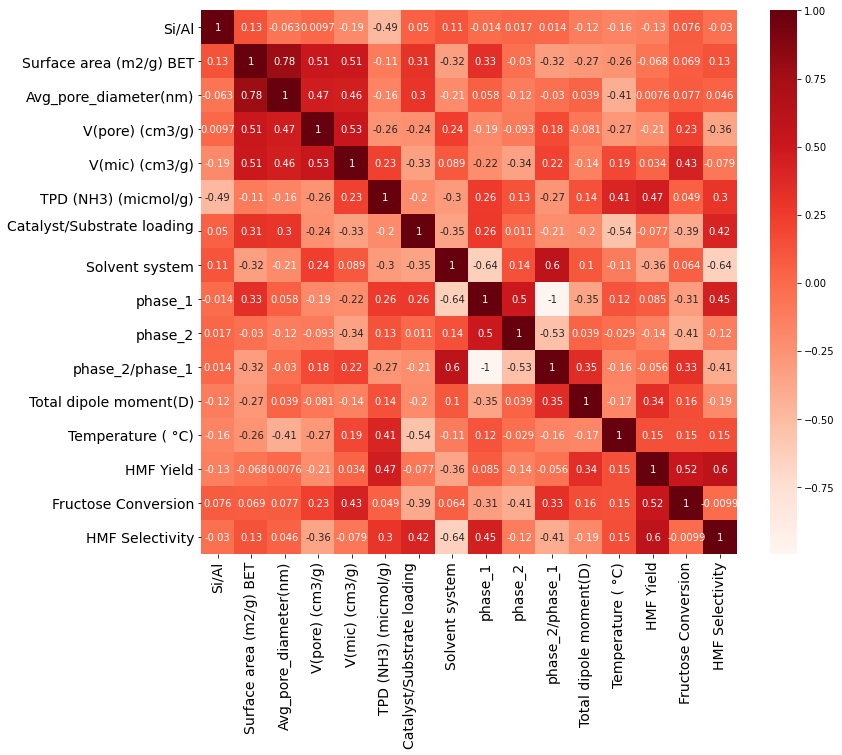

In [ ]:
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Covariance.png", bbox_inches='tight', dpi = 160)

## Trends

In [ ]:
from scipy.optimize import curve_fit
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [ ]:
x = [4.7,5.95,6.45,7.35]
y = [675,625, 120]

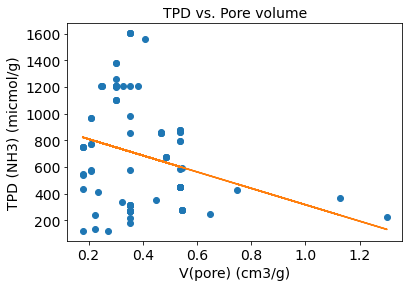

In [ ]:
x = df['V(pore) (cm3/g)']
y = df['TPD (NH3) (micmol/g)']
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('V(pore) (cm3/g)',fontsize=14)
plt.ylabel('TPD (NH3) (micmol/g)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("TPD vs. Pore volume", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/TPD_Pore_vol.png", bbox_inches='tight', dpi = 160)

In [ ]:
popt

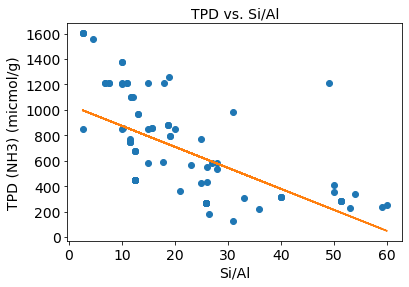

In [ ]:
x = df[df['Si/Al']<=60]['Si/Al']
y = df[df['Si/Al']<=60]['TPD (NH3) (micmol/g)']
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('Si/Al',fontsize=14)
plt.ylabel('TPD (NH3) (micmol/g)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("TPD vs. Si/Al", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/TPD_Si_Al.png", bbox_inches='tight', dpi = 160)

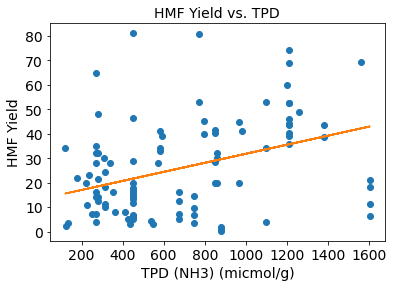

In [ ]:
x = df['TPD (NH3) (micmol/g)']
y = df["HMF Yield"]
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('TPD (NH3) (micmol/g)',fontsize=14)
plt.ylabel("HMF Yield",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("HMF Yield vs. TPD", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Yield_TPD.png", bbox_inches='tight', dpi = 160)

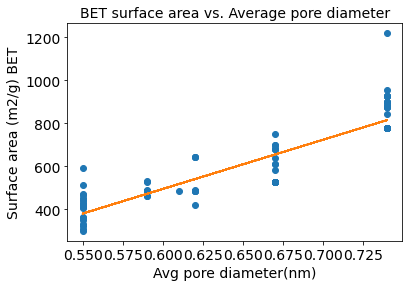

In [ ]:
x = df['Avg_pore_diameter(nm)']
y = df['Surface area (m2/g) BET']
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('Avg pore diameter(nm)',fontsize=14)
plt.ylabel("Surface area (m2/g) BET",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("BET surface area vs. Average pore diameter", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/BET_Pore_diameter.png", bbox_inches='tight', dpi = 160)

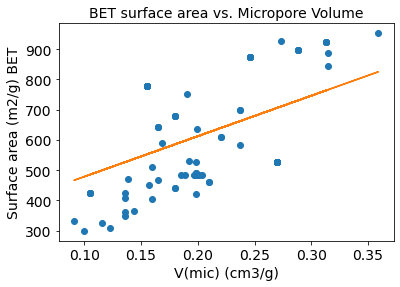

In [ ]:
x = df[df['Surface area (m2/g) BET']<=1000]['V(mic) (cm3/g)']
y = df[df['Surface area (m2/g) BET']<=1000]['Surface area (m2/g) BET']
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('V(mic) (cm3/g)',fontsize=14)
plt.ylabel("Surface area (m2/g) BET",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("BET surface area vs. Micropore Volume", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/BET_micro_pore.png", bbox_inches='tight', dpi = 160)

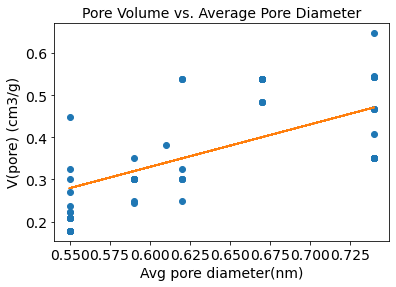

In [ ]:
x = df[df['V(pore) (cm3/g)']<=0.7]['Avg_pore_diameter(nm)']
y = df[df['V(pore) (cm3/g)']<=0.7]['V(pore) (cm3/g)']
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('Avg pore diameter(nm)',fontsize=14)
plt.ylabel('V(pore) (cm3/g)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Pore Volume vs. Average Pore Diameter", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/BET_micro_pore.png", bbox_inches='tight', dpi = 160)

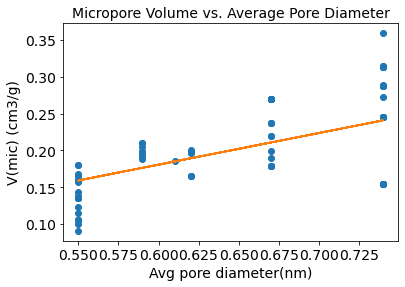

In [ ]:
x = df['Avg_pore_diameter(nm)']
y = df['V(mic) (cm3/g)']
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('Avg pore diameter(nm)',fontsize=14)
plt.ylabel('V(mic) (cm3/g)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Micropore Volume vs. Average Pore Diameter", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Micro_Pore_diameter.png", bbox_inches='tight', dpi = 160)

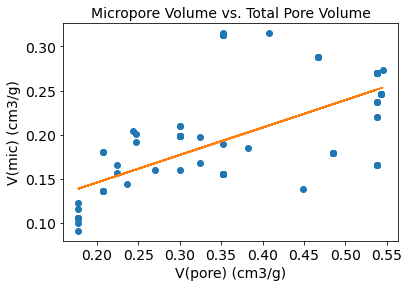

In [ ]:
x = df[df['V(pore) (cm3/g)']<=0.6]['V(pore) (cm3/g)']
y = df[df['V(pore) (cm3/g)']<=0.6]['V(mic) (cm3/g)']
popt, pcov = curve_fit(f, x, y) # your data x, y to fit
plt.plot(x,y, "o")
plt.plot(x,x*popt[0]+popt[1])
plt.xlabel('V(pore) (cm3/g)',fontsize=14)
plt.ylabel('V(mic) (cm3/g)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Micropore Volume vs. Total Pore Volume", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Micro_total_pore.png", bbox_inches='tight', dpi = 160)

## Model Predicted Trends

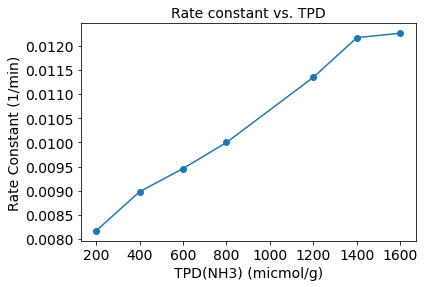

In [ ]:
x_1 = np.array([200,400,600,800,1200,1400,1600])
y_1 = np.array([0.00817,0.00898,0.00946,0.01,0.01135,0.01217,0.01226])
plt.plot(x_1,y_1,'-o')
plt.xlabel('TPD(NH3) (micmol/g)', fontsize = 14)
plt.ylabel('Rate Constant (1/min)', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Rate constant vs. TPD", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/k_TPD.png", bbox_inches='tight', dpi = 160)

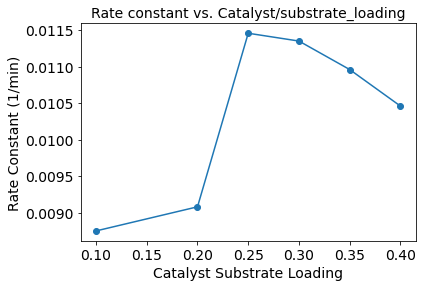

In [ ]:
x_2 = np.array([0.1,0.2,0.25,0.3,0.35,0.4])
y_2 = np.array([0.00875,0.009080,.011457,0.01135,0.01096,0.01046])
plt.plot(x_2,y_2, 'o-')
plt.xlabel('Catalyst Substrate Loading', fontsize = 14)
plt.ylabel('Rate Constant (1/min)', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Rate constant vs. Catalyst/substrate_loading", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/K_loading.png", bbox_inches='tight', dpi = 160)

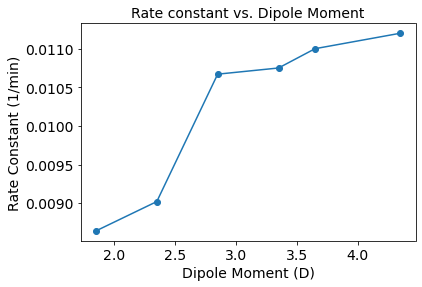

In [ ]:
x_3 = np.array([1.85,2.35,2.85,3.35,3.65,4.35])
y_3 = np.array([0.00864,0.00902,0.01067, 0.01075,0.011,0.0112])
plt.plot(x_3,y_3, '-o')
plt.xlabel('Dipole Moment (D)', fontsize = 14)
plt.ylabel('Rate Constant (1/min)', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Rate constant vs. Dipole Moment", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/K_Dipole.png", bbox_inches='tight', dpi = 160)

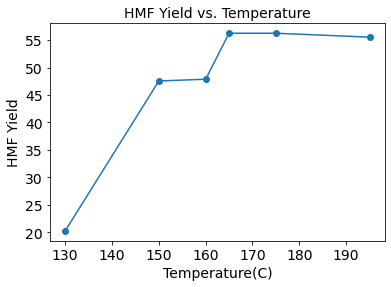

In [ ]:
x_3 = [130, 150, 160, 165, 175, 195]
y_3 = [20.25, 47.546,47.87, 56.24, 56.24, 55.53]
plt.plot(x_3,y_3, '-o')
plt.xlabel('Temperature(C)', fontsize = 14)
plt.ylabel('HMF Yield', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("HMF Yield vs. Temperature", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Y_Temp.png", bbox_inches='tight', dpi = 160)

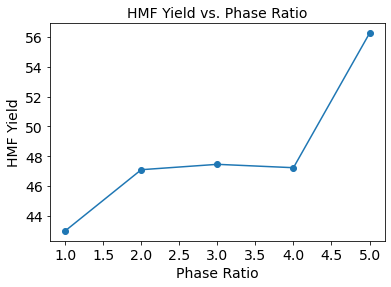

In [ ]:
x_3 = [1,2,3,4,5]
y_3 = [43,47.1,47.46, 47.234,56.24]
plt.plot(x_3,y_3, '-o')
plt.xlabel('Phase Ratio', fontsize = 14)
plt.ylabel('HMF Yield', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("HMF Yield vs. Phase Ratio", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Y_phase.png", bbox_inches='tight', dpi = 160)

## Linear regression Coefficients

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

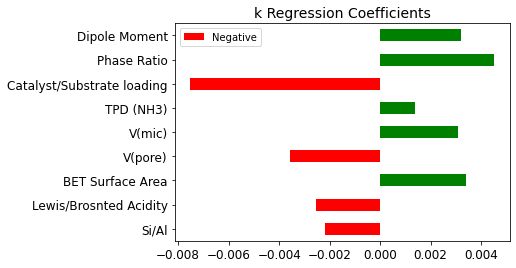

In [ ]:
data = pd.DataFrame([[-0.00216994], [-0.00253821],  [0.00340064],  [-0.0035692],
        [ 0.00310531], [0.00136722], [-0.00753685],  [0.00452543],
        [ 0.00319271]],
                    index=['Si/Al', 'Lewis/Brosnted Acidity', 'BET Surface Area', 'V(pore)', 'V(mic)',
       'TPD (NH3)', 'Catalyst/Substrate loading',
       'Phase Ratio', 'Dipole Moment'],
                    columns=['Negative'])
data['positive'] = data['Negative'] > 0
data['Negative'].plot(kind='barh',
                             color=data.positive.map({True: 'g', False: 'r'}) )
plt.title("k Regression Coefficients", fontsize=14)
plt.xticks(fontsize=12)
plt.legend()
plt.yticks(fontsize=12)
# images_dir = '/content/gdrive/My Drive'
# plt.savefig(f"{images_dir}/features.png", bbox_inches='tight',dpi= 160)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

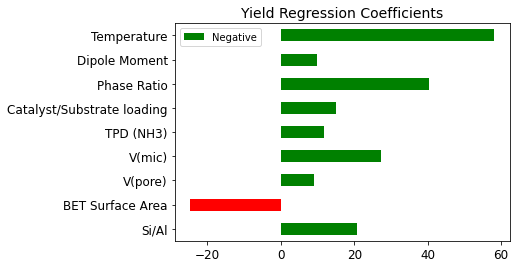

In [ ]:
data = pd.DataFrame([[20.71012833], [-24.74542046],  [9.04381888],  [27.34435608],
        [11.77319216],  [14.90523902],  [40.38366959],  [9.94233402],
        [58.12482426]],
                    index=['Si/Al', 'BET Surface Area', 'V(pore)', 'V(mic)',
       'TPD (NH3)', 'Catalyst/Substrate loading',
       'Phase Ratio', 'Dipole Moment', 'Temperature'],
                    columns=['Negative'])
data['positive'] = data['Negative'] > 0
data['Negative'].plot(kind='barh',
                             color=data.positive.map({True: 'g', False: 'r'}) )
plt.title("Yield Regression Coefficients", fontsize=14)
plt.xticks(fontsize=12)
plt.legend()
plt.yticks(fontsize=12)
# data['values'].plot(kind='barh', color= "g" )
# plt.title("Yield Regression Coeffients", fontsize=14)

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# images_dir = '/content/gdrive/My Drive'
# plt.savefig(f"{images_dir}/features_1.png", bbox_inches='tight',dpi= 160)

## Ea

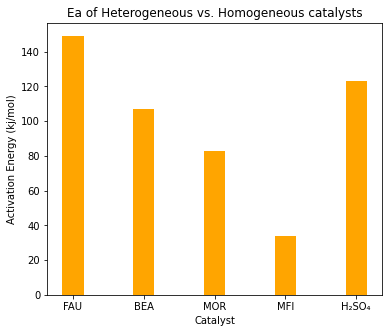

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 

labels = ["FAU", "BEA","MOR" , "MFI", "H₂SO₄"]
values= [149,107,83, 34.1,123]
  
fig = plt.figure(figsize = (6, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='orange',
        width = 0.3)
 
plt.xlabel("Catalyst")
plt.ylabel("Activation Energy (kj/mol)")
plt.title("Ea of Heterogeneous vs. Homogeneous catalysts")
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Ea_final.png", bbox_inches='tight', dpi = 160)

In [ ]:
["zsm","bea","usy","mor"]
[0.0085,0.0088,0.01,0.01055]
water,MIBK, 5

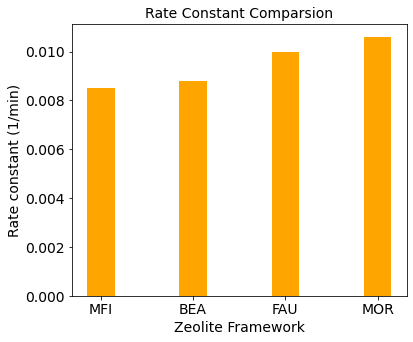

In [ ]:

labels = ["MFI", "BEA", "FAU","MOR"]
values= [0.0085,0.0088,0.010, 0.0106]
  
fig = plt.figure(figsize = (6, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='orange',
        width = 0.3)
 
plt.xlabel("Zeolite Framework", fontsize =14)
plt.ylabel("Rate constant (1/min)", fontsize =14)
plt.title("Rate Constant Comparsion", fontsize =14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/k_comparison.png", bbox_inches='tight', dpi = 160)

In [ ]:
# fig = plt.figure() # Create matplotlib figure

# ax = fig.add_subplot(111) # Create matplotlib axes
# ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

# width = 0.3

# df["Ea (kj/mol)"].plot(kind='bar', ax=ax, width=width, position=1)
# df["Micropore volume (cm^3/g)"].plot(kind='bar', color = "orange", ax=ax2, width=width, position=0)

# ax.set_ylabel('Ea (kj/mol)', size= 14)
# ax2.set_ylabel('Micropore volume (cm3/g)', size = 14)
# ax.set_xticklabels(["MFI", "MOR" , "BEA", "FAU", "H₂SO₄"], Fontsize= 14 ) 
# plt.legend()
# images_dir = '/content/gdrive/My Drive'
# plt.savefig(f"{images_dir}/trend.png", bbox_inches='tight', dpi = 160)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
 

# labels = ["MFI", "MOR","BEA", "FAU"]
# values= [415,475,605,908]
  
# fig = plt.figure(figsize = (6, 5))
 
# # creating the bar plot
# plt.bar(labels, values, color ='orange',
#         width = 0.3)
 
# plt.xlabel("Catalyst")
# plt.ylabel("BET Surface Area (m2/g)")
# #plt.title("Ea of Heterogeneous vs. Homogeneous catalysts")
# images_dir = '/content/gdrive/My Drive'
# plt.savefig(f"{images_dir}/BET.png", bbox_inches='tight', dpi = 160)

In [ ]:
labels= ["Dipole Moment", "TPD", "Si/Al", "BET Surface Area", "Catalyst/Substrate", "Micropore Volume"]
sizes = [0.29,0.21,0.17,0.09,0.08,0.06]
#colors
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.title("k prediction feature importance", size = 16)

#explsion
explode = (0.05,0.05,0.05,0.05, 0.05,0.05)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode,  textprops={'fontsize': 14})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/feature_importance_1.png", dpi = 160)

In [ ]:
labels= ["TPD",  "Dipole Moment", "Temperature", "Phases Ratio",  "Si/Al", "BET Surface Area"]
sizes = [0.25,0.21,0.2,0.12,0.06,0.05]
#colors
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
explode = (0.05,0.05,0.05,0.05, 0.05,0.05)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
plt.title("Yield prediction feature importance", size = 16)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/feature_importance_3.png", dpi = 160)